In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Preparação de códigos


A tarefa consiste em implementar uma MCMC para um processo com estados climáticos diários e a consequente simulação de variável contínua (precipitação de chuva) a fim de estimação de uma função de sua densidade de probabilidade (PDF). Para usufruir da PDF estimada, duas questões são postas ao final deste *notebook* referentes à previsão desta grandeza, mais especificamente, sobre probabilidade de faixas de valores de precipitação anual.

Todos os dados aqui apresentados são fictícios e não incluem uma análise ou dependência da estação do ano que seria importante numa análise como essa.

## Parte 1: Definindo a cadeia de Markov

Para facilitar o trabalho, incluo aqui uma proposta de classe para *Markov Chains*:

In [ ]:
class MC:
    def __init__(self, states, probs, init=0):
        self.states = states.split("|")
        self.probs = np.array(probs)
        if any(p != len(self.states) for p in self.probs.shape):
            raise Exception("Probabilidades não se adequam ao número de estados")
        self.current = init if init < len(self.states) else 0
    def next(self):
        probs = np.cumsum(self.probs[self.current,:])
        if np.abs(1 - probs[-1]) > 1e-12:
            raise Exception(f"Probabilidades não somam 100% para estado"
                f" {self.current} ({self.current_state()})")
        rn = np.random.random()
        for i in range(probs.shape[0]):
            if rn < probs[i]:
                self.current = i
                return i
    def next_state(self):
        self.next()
        return self.current_state()
    def current_state(self):
        return self.states[self.current]

Com base na cadeia de Markov representada pelo grafo a seguir (cada estado é um dia neste cenário), 

![](https://github.com/iperetta/FEELT31723/raw/main/clima.png)

Preencha a tabela de probabilidades para os estados:

- 0 : Aberto
- 1 : Encoberto
- 2 : Nublado
- 3 : Chuvoso
- 4 : Tempestivo

e rode o código abaixo:

In [ ]:
clima = MC("Aberto|Encoberto|Nublado|Chuvoso|Tempestivo", 
           [[0.70,   0.20,    0.05,   0.03,    0.02],
            [0.30,   0.35,    0.25,   0.07,    0.03],
            [0.10,   0.30,    0.35,   0.20,    0.05],
            [0.15,   0.20,    0.30,   0.20,    0.15],
            [0.02,   0.03,    0.45,   0.34,    0.16]
           ])

# Para testar, rode esta célula até que 
# todos os estados sejam apresentados pelo menos uma vez:
for i in range(10):
    print(clima.current_state())
    clima.next()

Aberto
Tempestivo
Nublado
Nublado
Encoberto
Nublado
Encoberto
Aberto
Aberto
Aberto


## Parte 2: Definindo a geração dos dados diários

Partindo da premissa de que a cada estado (ou dia) temos uma precipitação em milimetros com distribuição normal, mas diferentes média e desvio-padrão por estado, no código a seguir preencha a parte decisória da função aninhada `daily_rainfall` com os seguintes dados para os estados:

- 0 : Aberto $\Rightarrow \mu = 0.026, \;\sigma = 0.005$
- 1 : Encoberto $\Rightarrow \mu = 0.26, \;\sigma = 0.05$
- 2 : Nublado $\Rightarrow \mu = 1.4, \;\sigma = 0.4$
- 3 : Chuvoso $\Rightarrow \mu = 5, \;\sigma = 1$
- 4 : Tempestivo $\Rightarrow \mu = 12, \;\sigma = 2$

Note que esses valores foram empiricamente determinados para que se tivesse uma precipitação anual coerente com os dados climáticos encontrados na internet, mas não condizem com nenhuma realidade específica.

Dia 1: Aberto 
Dia 2: Aberto 
Dia 3: Aberto 
Dia 4: Aberto 
Dia 5: Aberto 
Dia 6: Aberto 
Dia 7: Tempestivo 
Dia 8: Chuvoso 
Dia 9: Tempestivo 
Dia 10: Chuvoso 
Acumulado em 10 dias: 36.11 mm


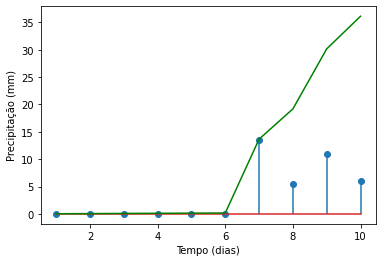

In [ ]:
def simulate_days(weather, ndays, verbose=False):
    def daily_rainfall(weather, verbose=False):
        if(weather.current_state() == "Aberto"):
          mu = 0.026
          sigma = 0.005
        elif(weather.current_state() == "Encoberto"):
          mu = 0.26
          sigma = 0.05
        elif(weather.current_state() == "Nublado"):
          mu = 1.4
          sigma = 0.4
        elif(weather.current_state() == "Chuvoso"):
          mu = 5
          sigma = 1
        elif(weather.current_state() == "Tempestivo"):
          mu = 12
          sigma = 2
        rainfall = np.random.normal(loc=mu,scale=sigma) # sorteio de valor com distribuição normal
        if verbose: print(weather.current_state(), end=" ")
        weather.next()
        return rainfall if rainfall > 0 else 0
    rainfall = []
    for d in range(ndays):
        if verbose: print(f"Dia {d+1}:", end=" ")
        rainfall.append(daily_rainfall(weather, verbose))
        if verbose: print("")
    return rainfall # lista com a precipitação de todos os dias simulados

# Para testar, verifique se a precipitação indicada condiz com o estado do dia:
dias = 10
mmchuva = simulate_days(clima, dias, verbose=True)
acumulado = np.cumsum(mmchuva)
print(f"Acumulado em {dias} dias: {acumulado[-1]:0.2f} mm")
plt.stem(range(1,dias+1),mmchuva, use_line_collection=True)
plt.xlabel("Tempo (dias)")
plt.ylabel("Precipitação (mm)")
plt.plot(range(1,dias+1),acumulado,'g')
plt.show()

## Parte 3: Definindo a simulação da precipitação anual

Gere o código necessário para simular `niter` vezes a precipitação anual (365 dias) e colete os resultados para gerar o histograma e consequente KDE das precipitações anuais simuladas.

**Dica:** Utilize `np.sum(simulate_days(weather, ndays))` para obter o valor de precipitação anual para cada iteração da simulação.

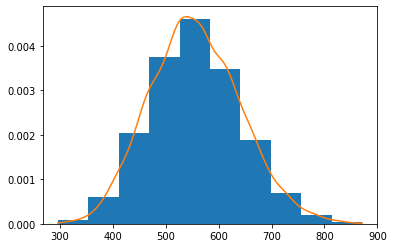

In [ ]:
def simulate(weather, ndays, niter):
    precipitacoesAnuais = []
    for _ in range(niter):
        ano = np.sum(simulate_days(weather, ndays))
        precipitacoesAnuais.append(ano)
    return precipitacoesAnuais

dias = 365
niter = 10000 # troque por um valor que achar coerente (note que a simulação demanda um certo poder computacional)
dados = simulate(clima, dias, niter)
_, bins, _ = plt.hist(dados, density=True)
kde = stats.gaussian_kde(dados)
xkde = np.linspace(np.min(bins), np.max(bins), 100)
plt.plot(xkde, kde(xkde))
plt.show()



# Questões

Para facilitar o trabalho, incluo aqui a Quadratura de Gauss Legendre:

In [ ]:
def legendre_coefficients(n):
    aux = np.polynomial.legendre.leg2poly([0]*(n-1) + [1])
    return np.reshape(aux, (aux.shape[0], 1))

def quadrature_nodes(n_points):
    coeffs = list(reversed(legendre_coefficients(n_points+1).flatten().tolist()))
    roots = np.roots(coeffs).tolist()
    return np.array(sorted(roots))

def quadrature_weights(n_points):
    if n_points == 1:
        return np.array([2])
    nodes = quadrature_nodes(n_points)
    nodes = np.reshape(nodes, (nodes.shape[0], 1))
    coeffs = list(reversed(legendre_coefficients(n_points+1).flatten().tolist()))
    d_coeffs = np.polyder(coeffs)
    dN = d_coeffs.shape[0]
    d_coeffs = np.reshape(d_coeffs, (dN, 1))
    aux = np.ones((nodes.shape[0], 1))
    for n in range(1, dN):
        aux = np.c_[nodes**n, aux]
    dPn = (aux @ d_coeffs).flatten()
    return 2/((1 - nodes.flatten()**2)*dPn**2)

def qgl(f, a, b, N):
    if a > b: raise Exception(f"a={a} e b={b}; a > b não pode ser integrado")
    x = quadrature_nodes(N)
    w = quadrature_weights(N)
    return (b-a)/2*np.sum(w*f((b-a)/2*x+(b+a)/2))

### A) Qual a probabilidade dentro deste cenário de termos uma precipitação anual **maior do que** 750mm ?
**Dica:** Utilize `np.max(dados)` como limite superior de integração

In [ ]:
f = kde
a = 750
b = np.max(dados)
for N in (5,10,15,20):
  print(f"N={N}: ", qgl(f, a, b, N))

b = b*10**2  # tentei fazer com 10**3 como sugerido em aula, mas ele retornou tudo 0.0
print("\n\nPara limite superior igual à np.max(dados)*10^2:") 
for N in (25,30,35,40):  # N teve que ser maior aqui para que retornasse valores mais próximos
  print(f"N={N}: ", qgl(f, a, b, N))

N=5:  0.01691523163697021
N=10:  0.016922001419219325
N=15:  0.016922032819434874
N=20:  0.016922032847199762


Para limite superior igual à np.max(dados)*10^2:
N=25:  1.873074895695011e-09
N=30:  0.0009445791996814506
N=35:  0.007363631558873136
N=40:  0.013205456325533844


### B) Qual a probabilidade dentro deste cenário de termos uma precipitação anual **menor do que** 400mm ?
**Dica:** Utilize `np.min(dados)` como limite inferior de integração

In [ ]:
f = kde
a = np.min(dados)
b = 400
for N in (5,10,15,20):
  print(f"N={N}: ", qgl(f, a, b, N))

a = 0
print("\n\nPara limite inferior igual à 0:")
for N in (5,10,15,20):
  print(f"N={N}: ", qgl(f, a, b, N))

N=5:  0.0286937682551688
N=10:  0.028681651373742862
N=15:  0.028681650810087164
N=20:  0.02868165081111519


Para limite inferior igual à 0:
N=5:  0.030001808885441756
N=10:  0.02870758757612088
N=15:  0.0288800790094038
N=20:  0.028839515334155685
